# Modelling BG

## Model Shapping

In [1]:
# Importing the libraries
import numpy as np
import os
import pandas as pd

In [2]:
train_data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
train_data = pd.read_csv(train_data_file, index_col=0, low_memory=False)
validation_data_file = os.path.join('..', '..', '..', '..', 'data', 'interim', 'all_test_3h.csv')
validation_data = pd.read_csv(validation_data_file, low_memory=False)

## Train XGBoost model

In [3]:
# Load and preprocess the train data 
from pipelines import pipeline
from src.features.tuners import XGBHyperparameterTuner
from sklearn.metrics import root_mean_squared_error

train_and_validation_data = pipeline.fit_transform(pd.concat([train_data, validation_data]))

X = train_and_validation_data.drop(columns=['bg+1:00'])
y = train_and_validation_data['bg+1:00']

tuner = XGBHyperparameterTuner()
model = tuner.regressor()

y_log = np.log1p(y)
model.fit(X=X, y=y_log)

y_pred_log = model.predict(X=X)
y_pred = np.expm1(y_pred_log)

root_mean_squared_error(y_true=y, y_pred=y_pred)

np.float64(1.796351646578227)

## Feature importance

In [4]:
from src.features.helpers import ShapWrapper

shp = ShapWrapper(model=model, X=X)
features = shp.get_top_features_df()
features

,feature,mean_abs_shap_value
36,bg-0:00,0.208476
35,bg-0:05,0.018501
34,bg-0:10,0.013512
33,bg-0:15,0.011111
110,hr-0:00,0.009281
...,...,...
112,steps-2:55,0.000151
113,steps-2:50,0.000139
115,steps-2:40,0.000107
120,steps-2:15,0.000065


In [5]:
from tqdm.notebook import tqdm
import numpy as np

rmses = {}

train_data_transformed = pipeline.fit_transform(train_data)
validation_data_transformed = pipeline.transform(validation_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_val = validation_data_transformed.drop(columns=['bg+1:00'])
y_val = validation_data_transformed['bg+1:00']

for i in tqdm(range(1, len(shp.get_top_features()))):
    X_train_loop = X_train[shp.get_top_features(i)]
    X_val_loop = X_val[shp.get_top_features(i)]
    model = tuner.regressor()

    y_log = np.log1p(y_train)
    model.fit(X=X_train_loop, y=y_log)

    y_pred_log = model.predict(X=X_val_loop)
    y_pred = np.expm1(y_pred_log)

    rmses[i] = root_mean_squared_error(y_val, y_pred)


  0%|          | 0/207 [00:00<?, ?it/s]

## Standardization

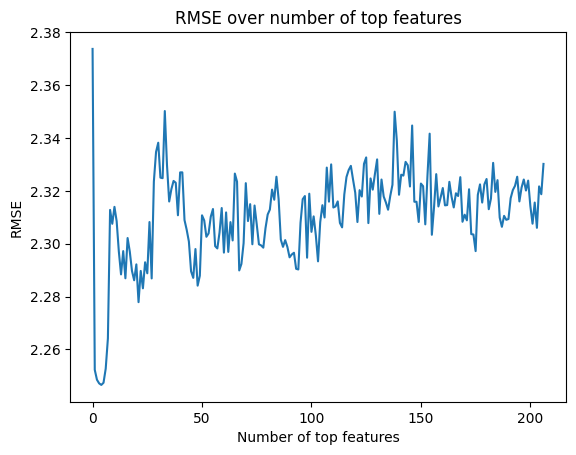

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rmses.values())
plt.title('RMSE over number of top features')
plt.xlabel('Number of top features')
plt.ylabel('RMSE')
plt.show()

In [7]:
# Find the key with the minimum value
min_key = min(rmses, key=rmses.get)

print("Index with the minimum value:", min_key)
print("Minimum value:", rmses[min_key])

Index with the minimum value: 5
Minimum value: 2.246521761132507


In [9]:
shp.get_top_features(5)

['bg-0:00', 'bg-0:05', 'bg-0:10', 'bg-0:15', 'hr-0:00']